In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
def normalize_z(dfin, columns_means=None, columns_stds=None):
    if columns_means is None:
        columns_means = dfin.mean()
    if columns_stds is None:
        columns_stds = dfin.std()
        
    dfout = (dfin - columns_means) / columns_stds
        
    return dfout, columns_means, columns_stds

#feature_names and target_names are lists
def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names].copy()
    df_target = df[target_names].copy()
    
    return df_feature, df_target

#Convert to numpy, and add a column of 1s
def prepare_feature(df_feature):
    #Assume df feature CANNOT be a series because get_features_targets makes sure that they are dataframes
    if isinstance(df_feature, pd.DataFrame):
        np_feature = df_feature.to_numpy()
    else:
        np_feature = df_feature
        
    #Get number of rows
    num_rows = np_feature.shape[0]
    #Create a column of ones
    ones_col = np.ones((num_rows, 1))
    
    #Concatenate them horizontally
    X = np.concatenate((ones_col, np_feature), axis=1)
    
    #Return X
    return X
    

def prepare_target(df_target):
    #Assume df target CANNOT be a series because get_features_targets makes sure that they are dataframes
    if isinstance(df_target, pd.DataFrame):
        np_target = df_target.to_numpy()
    else:
        np_target = df_target
        
    return np_target #this is just y

    
#Normalizes features, prepare the data, then do prediction
def predict_linreg(df_feature, beta, means=None, stds=None):
    #Normalize features
    df_feature_z, _, _ = normalize_z(df_feature, means, stds)
    
    #Prepare the feature (convert to numpy and add column of 1)
    X = prepare_feature(df_feature_z) #I FORGOT THE Z FFS
    
    ypred = calc_linreg(X, beta)
    
    return ypred
    

def calc_linreg(X, beta):
    #Its just ypred = Xb #X matrix multiply b
    return np.matmul(X, beta)
    

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
     
    #Get all indexs
    all_indexs = df_target.index #can take from df_feature too, doesnt matter
    
    #Get the test indexs
    np.random.seed(random_state)
    
    test_indexs = sorted(list(np.random.choice(all_indexs, size = int(len(all_indexs)*test_size), replace = False)))
    
    #Start splitting
    df_feature_test = df_feature.loc[test_indexs, : ]
    df_target_test = df_target.loc[test_indexs, : ]
    
    df_feature_train = df_feature.drop(test_indexs)
    df_target_train = df_target.drop(test_indexs)
    
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    residuals = y-ypred
    SSres = np.matmul(residuals.T, residuals)
    #print(SSres)

    totals = y - np.mean(y)
    SStot = np.matmul(totals.T, totals)
    #print(SStot)
    
    r2 = 1 - (SSres/SStot)
    return r2[0][0]

def mean_squared_error(target, pred):
    error = target - pred
    mse = np.matmul(error.T, error) / len(pred)
    return mse[0][0]

In [26]:
# def r2_score(y, ypred):
#     error_res = y - ypred
#     error_res_square = np.matmul(error_res.T, error_res)
#     res = error_res_square

#     n = y.shape[0]
#     row_ones = np.ones((1, n))
#     mean = 1 / n * (np.matmul(row_ones, y))
#     error_tot = y - mean
#     error_tot_square = np.matmul(error_tot.T, error_tot)
#     tot = error_tot_square

#     r2 = 1 - (res / tot)

#     return r2

In [58]:
def compute_cost_linreg(X, y, beta):
    #Get predictions
    ypred = calc_linreg(X, beta)
    
    #Get errors (residuals)
    errors = y - ypred
    
    #Calculate cost (loss)
    m = y.shape[0] #Number of rows / datapoints #Can take x.shape[0], its the same
    J = (np.matmul(errors.T, errors)) / (2*m)
    
    return J[0][0]

def gradient_descent_linreg(X, y, beta, alpha, num_iters):
    J_storage = np.zeros(num_iters)
    
    m = y.shape[0]
    for i in range(num_iters):
        #Get the prediction
        ypred = calc_linreg(X, beta)
        
        #Get the error
        errors = ypred - y #MUST BE YPRED - Y NOT THE OTHER WAY AROUND. 
        
        #Get the derivative
        derivs = np.matmul(X.T, errors) / m
        
        #Calculate the new beta
        beta = beta - (alpha*derivs)
        
        #Calculate the cost
        J = compute_cost_linreg(X, y, beta)
        
        #Add cost to Jstorage
        J_storage[i] = J
        
    return beta, J_storage

In [59]:
# Read the CSV file
df = pd.read_csv("indo_plp_vnm_thai_combined.csv")

# Extract the features and the targets
df_features, df_target = get_features_targets(df, [
    #"Amount of Rice (hg/ha)",
    "Rice Produced (tonnes)",
    #"Inflation, consumer prices (annual %)",
    "GDP per capita (constant 2015 US$)",
    "Average Producer Price of Rice per kg (USD)",
    "Population Size", 
    "No. of Extreme Weather Events"], 
    ["Average Consumer Price of Rice per kg (USD)"])

In [66]:
# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize the features using z normalization
df_features_train_z, means, stds = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)


iterations = 1500
alpha = 0.01
beta = np.zeros((X.shape[1],1))

# Call the gradient_descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict_linreg(df_features_test, beta, means, stds) #Predict with TEST DATA

# change target test set to a numpy array
target = prepare_target(df_target_test)

# # Calculate r2 score by calling a function
# r2 = r2_score(target, pred)

# print(r2)

# # Calculate the mse
# mse = mean_squared_error(target, pred)

# print(mse)

print(beta)

print(list(zip(["Constant"]+list(df_features.columns), list(beta))))

[[ 0.5259573 ]
 [-0.10133133]
 [ 0.02419355]
 [ 0.1049819 ]
 [ 0.19333818]
 [ 0.02366352]]
[('Constant', array([0.5259573])), ('Rice Produced (tonnes)', array([-0.10133133])), ('GDP per capita (constant 2015 US$)', array([0.02419355])), ('Average Producer Price of Rice per kg (USD)', array([0.1049819])), ('Population Size', array([0.19333818])), ('No. of Extreme Weather Events', array([0.02366352]))]


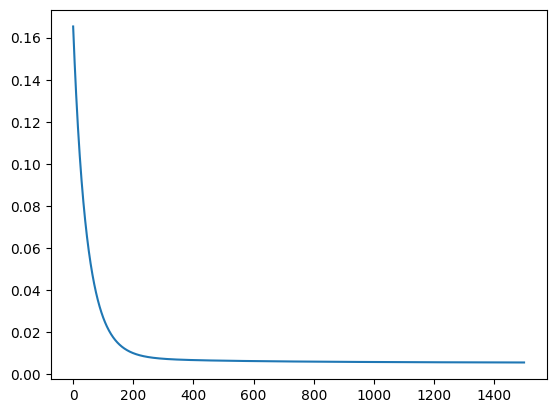

In [61]:
plt.plot(J_storage)

Text(0.5, 1.0, 'Average Consumer Price per kg (USD) vs No. of Extreme Weather Events')

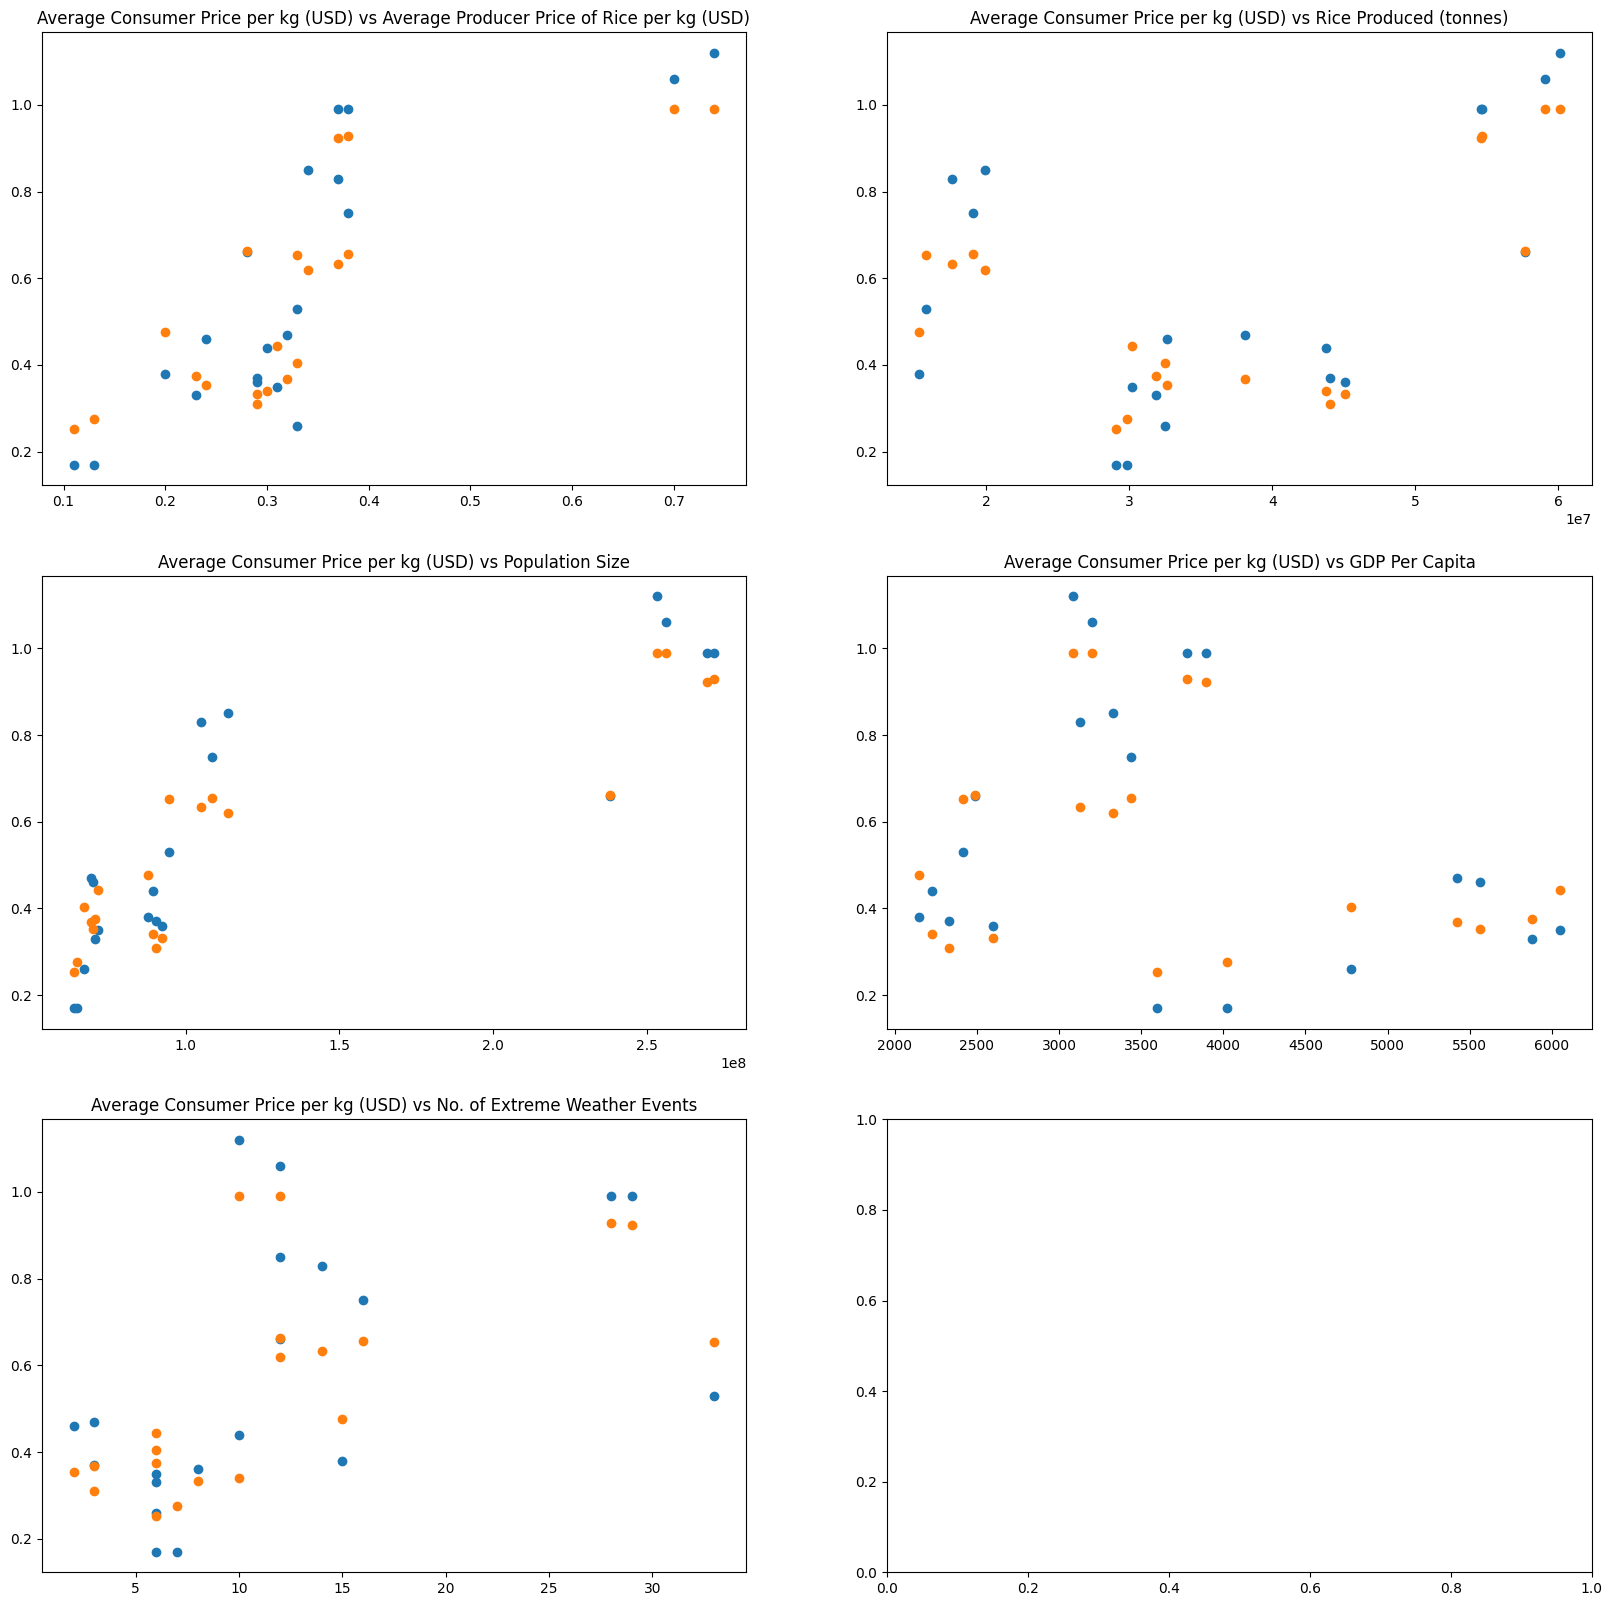

In [62]:
pred = predict_linreg(df_features_test, beta, means, stds) #Predict with TEST DATA


fig, axs = plt.subplots(3, 2, figsize=(20,20))

axs[0,0].scatter(df_features_test["Average Producer Price of Rice per kg (USD)"], df_target_test)
axs[0,0].scatter(df_features_test["Average Producer Price of Rice per kg (USD)"], pred)
axs[0,0].set_title('Average Consumer Price per kg (USD) vs Average Producer Price of Rice per kg (USD)')

axs[0,1].scatter(df_features_test["Rice Produced (tonnes)"], df_target_test)
axs[0,1].scatter(df_features_test["Rice Produced (tonnes)"], pred)
axs[0,1].set_title('Average Consumer Price per kg (USD) vs Rice Produced (tonnes)')


axs[1,0].scatter(df_features_test["Population Size"], df_target_test)
axs[1,0].scatter(df_features_test["Population Size"], pred)
axs[1,0].set_title('Average Consumer Price per kg (USD) vs Population Size')


axs[1,1].scatter(df_features_test["GDP per capita (constant 2015 US$)"], df_target_test)
axs[1,1].scatter(df_features_test["GDP per capita (constant 2015 US$)"], pred)
axs[1,1].set_title('Average Consumer Price per kg (USD) vs GDP Per Capita')


axs[2,0].scatter(df_features_test["No. of Extreme Weather Events"], df_target_test)
axs[2,0].scatter(df_features_test["No. of Extreme Weather Events"], pred)
axs[2,0].set_title('Average Consumer Price per kg (USD) vs No. of Extreme Weather Events')





Text(0.5, 1.0, 'Average Consumer Price per kg (USD) vs No. of Extreme Weather Events')

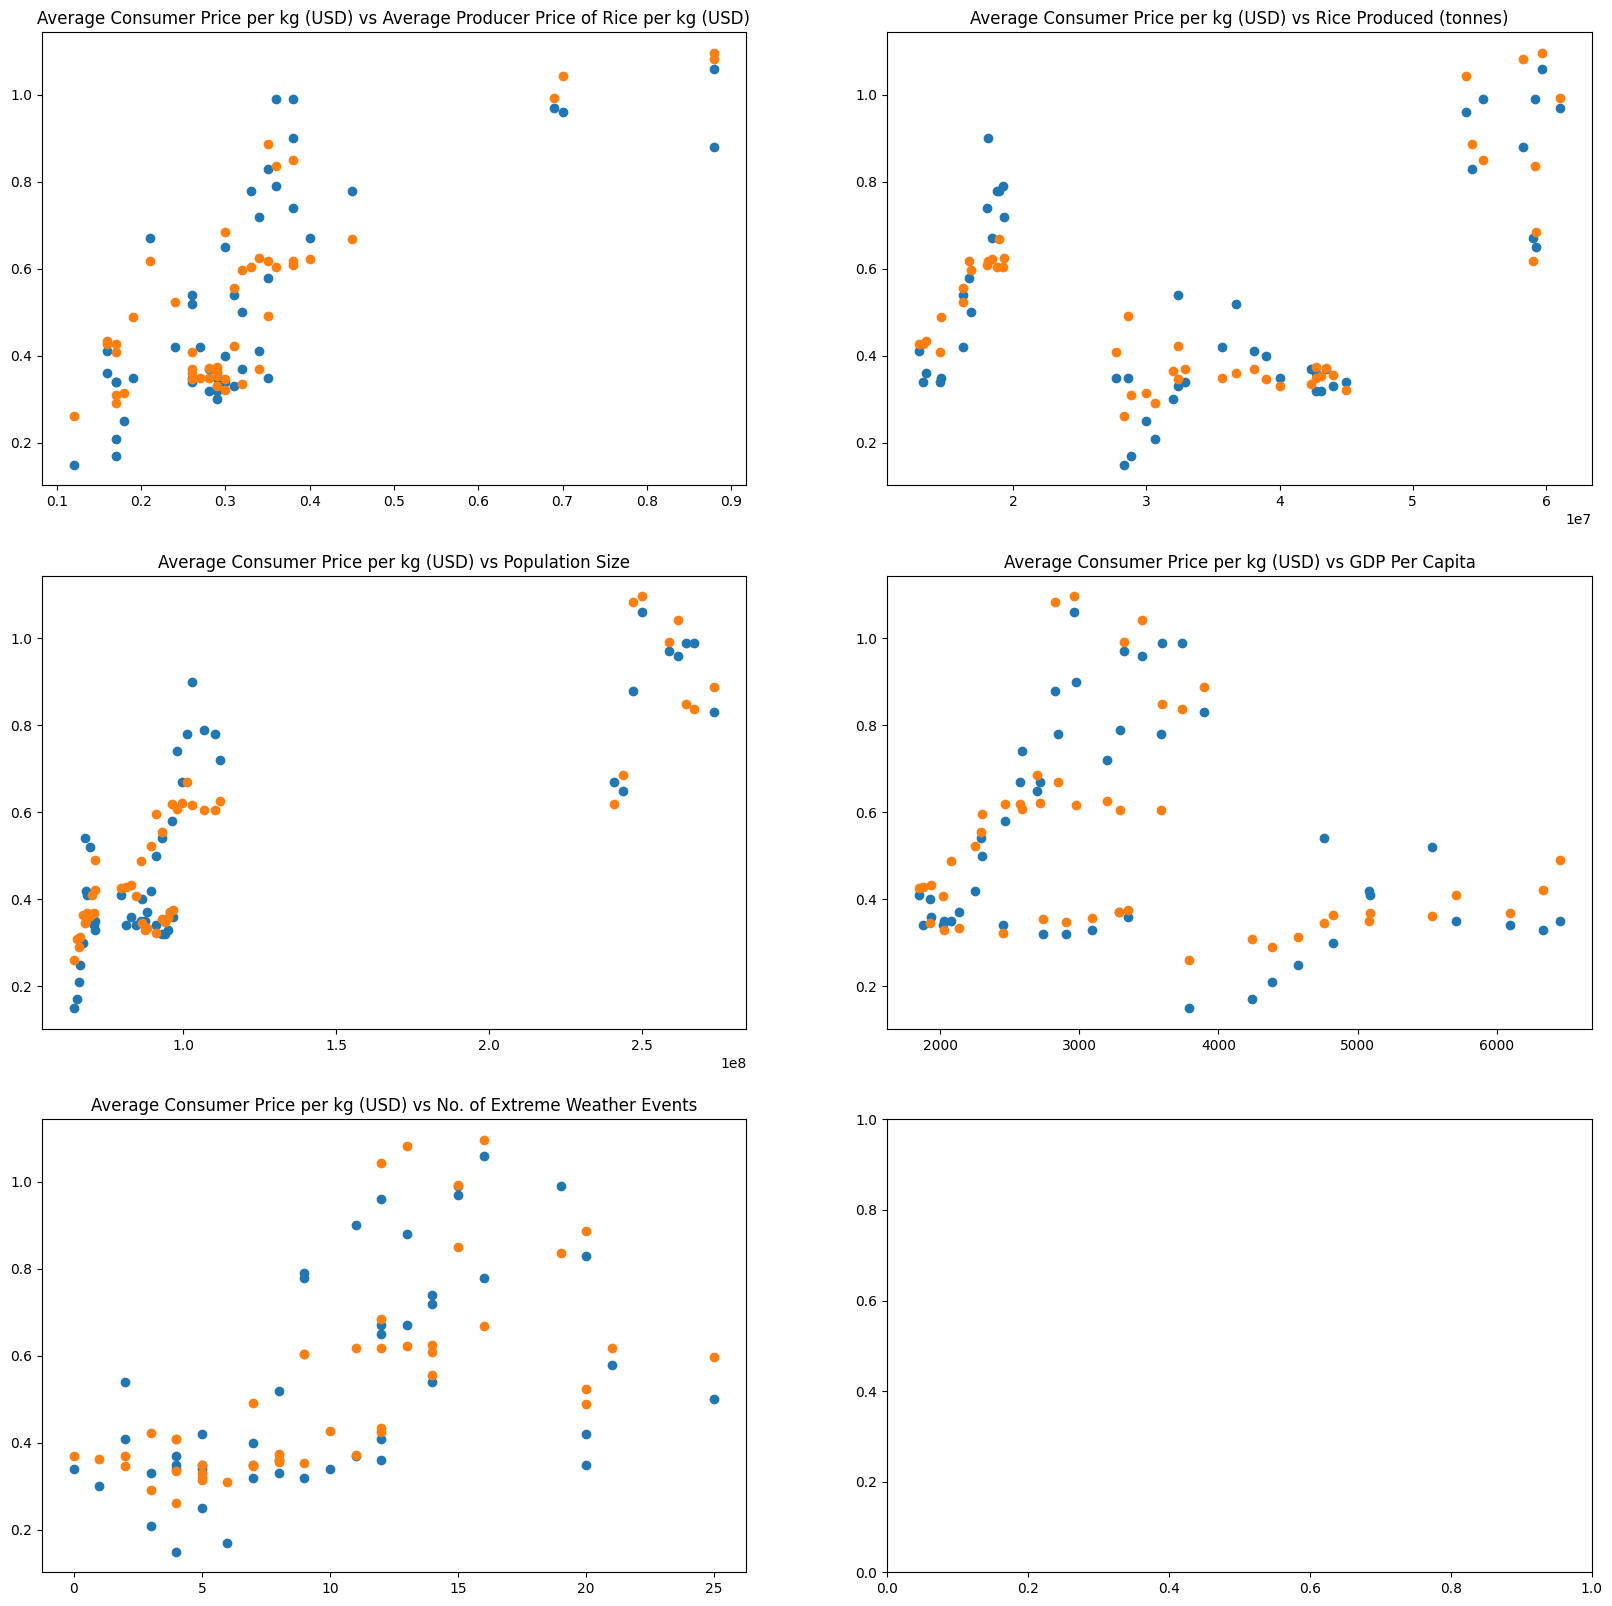

In [63]:
pred_with_train = predict_linreg(df_features_train, beta, means, stds) #Predict with TRAIN DATA


fig, axs = plt.subplots(3, 2, figsize=(20,20))

axs[0,0].scatter(df_features_train["Average Producer Price of Rice per kg (USD)"], df_target_train)
axs[0,0].scatter(df_features_train["Average Producer Price of Rice per kg (USD)"], pred_with_train)
axs[0,0].set_title('Average Consumer Price per kg (USD) vs Average Producer Price of Rice per kg (USD)')

axs[0,1].scatter(df_features_train["Rice Produced (tonnes)"], df_target_train)
axs[0,1].scatter(df_features_train["Rice Produced (tonnes)"], pred_with_train)
axs[0,1].set_title('Average Consumer Price per kg (USD) vs Rice Produced (tonnes)')

axs[1,0].scatter(df_features_train["Population Size"], df_target_train)
axs[1,0].scatter(df_features_train["Population Size"], pred_with_train)
axs[1,0].set_title('Average Consumer Price per kg (USD) vs Population Size')


axs[1,1].scatter(df_features_train["GDP per capita (constant 2015 US$)"], df_target_train)
axs[1,1].scatter(df_features_train["GDP per capita (constant 2015 US$)"], pred_with_train)
axs[1,1].set_title('Average Consumer Price per kg (USD) vs GDP Per Capita')

axs[2,0].scatter(df_features_train["No. of Extreme Weather Events"], df_target_train)
axs[2,0].scatter(df_features_train["No. of Extreme Weather Events"], pred_with_train)
axs[2,0].set_title('Average Consumer Price per kg (USD) vs No. of Extreme Weather Events')

In [64]:
#Save beta, means and stds values as pickle
import pickle as pkl
with open("combined_beta_means_stds.pkl", "wb") as f1:

    pkl.dump((beta, means, stds), f1)
